In [36]:
import numpy as np

REG0 = 0*4
REG1 = 1*4
FIFO = 2*4

BIT_LAYER_END = 0b010
BIT_MOVE_DONE = 0b100

def write_reg(mmio, addr, val):
    mmio.write(addr, int(val))
    _ = mmio.read(REG1)   # flush/順序目的：必ず安全なREG1を読む

def write_fifo(mmio, val):
    mmio.write(FIFO, int(val))
    # ★ここが重要：FIFOアドレスをreadしない
    # flushしたいならREG1を読む（ただし毎回は重いので間引くのがおすすめ）
    # _ = mmio.read(REG1)

def wait_bit(mmio, mask):
    while True:
        s = mmio.read(REG1)
        if (s & mask) == mask:
            return s

def s8_stream_from_txt(path):
    with open(path, "r") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            yield int(s)

def pack4_s8_to_u32(a0, a1, a2, a3):
    b0 = np.uint8(np.int8(a0))
    b1 = np.uint8(np.int8(a1))
    b2 = np.uint8(np.int8(a2))
    b3 = np.uint8(np.int8(a3))
    return (np.uint32(b3) << 24) | (np.uint32(b2) << 16) | (np.uint32(b1) << 8) | np.uint32(b0)

def next_word_from_s8(gen):
    vals = []
    for _ in range(4):
        try:
            vals.append(next(gen))
        except StopIteration:
            vals.append(0)
    return int(pack4_s8_to_u32(vals[0], vals[1], vals[2], vals[3]))

def pack2_s16_to_u32(a0, a1):
    # s16 -> u16
    lo = np.uint16(np.int16(a0))
    hi = np.uint16(np.int16(a1))

    # a0 が上位16bit, a1 が下位16bit
    return (np.uint32(hi) << 16) | np.uint32(lo)

def next_word_from_s16(gen):
    vals = []
    for _ in range(2):
        try:
            vals.append(next(gen))
        except StopIteration:
            vals.append(0)
    return int(pack2_s16_to_u32(vals[0], vals[1]))

def run_layer_from_txt(mmio, weight_txt_path, ch_max, s8_per_ch, toC_val, start_val, wait_move_done=True):
    words_per_ch = s8_per_ch // 4
    if s8_per_ch % 4 != 0:
        raise ValueError("s8_per_ch must be multiple of 4")

    g = s8_stream_from_txt(weight_txt_path)

    for ch in range(ch_max):
        write_reg(mmio, REG0, toC_val)

        for k in range(words_per_ch):
            w = next_word_from_s8(g)
            write_fifo(mmio, w)

            # 任意：たまにflush（毎回は重い）
            if (k & 0xFF) == 0:   # 256wordごと
                _ = mmio.read(REG1)

        write_reg(mmio, REG0, start_val)

        wait_bit(mmio, BIT_LAYER_END)
        print(f"done: {weight_txt_path} ch={ch}")

    if wait_move_done:
        wait_bit(mmio, BIT_MOVE_DONE)
        print(f"move_done: {weight_txt_path}")

    
def mmio_write_flush(mmio, addr, val):
    mmio.write(addr, int(val))
    _ = mmio.read(addr)   # write posting / 順序の強制を狙う

def s8_stream_from_txt(path):
    with open(path, "r") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            yield int(s)

def pack4_s8_to_u32(a0, a1, a2, a3):
    # s8 -> u8
    b0 = np.uint8(np.int8(a0))
    b1 = np.uint8(np.int8(a1))
    b2 = np.uint8(np.int8(a2))
    b3 = np.uint8(np.int8(a3))

    # ★ここはHW/TBの規約に依存
    # TB側(pack4_u32(x3,x2,x1,x0))に合わせるなら「a3がMSB、a0がLSB」が多い
    return (np.uint32(b3) << 24) | (np.uint32(b2) << 16) | (np.uint32(b1) << 8) | np.uint32(b0)

def next_word_from_s8(gen):
    vals = []
    for _ in range(4):
        try:
            vals.append(next(gen))
        except StopIteration:
            vals.append(0)
    return int(pack4_s8_to_u32(vals[0], vals[1], vals[2], vals[3]))

def send_input_x_from_txt(mmio, x_txt_path):
    g = s8_stream_from_txt(x_txt_path)  # ※値は int として読むだけなので流用OK

    # reset 相当（既存仕様踏襲）
    mmio_write_flush(mmio, REG0, 1)

    # x は 100個 -> s16×2 = 32bit を 50word 送る
    for i in range(50):
        w = next_word_from_s16(g)
        mmio_write_flush(mmio, FIFO, w)
        print(f"x word {i}: 0x{w:08X}")

    # input_datacontrol 開始
    mmio_write_flush(mmio, REG0, 3)

In [37]:
from pynq import Overlay
pl = Overlay('./design_1_wrapper.bit')

# 通信部コード名あっているかは確認するべき
from pynq import MMIO
mmio = MMIO(pl.ip_dict['AXI_LITE_source_v1_0_0']['phys_addr'], pl.ip_dict['AXI_LITE_source_v1_0_0']['addr_range'])

In [38]:
import time
from time import sleep
FIFO_A = 2*4
t0 = time.perf_counter()

# 入力の送信
send_input_x_from_txt(mmio, "z2_5.txt")

sleep(0.01)

# １層目の計算
run_layer_from_txt(
    mmio,
    weight_txt_path="clean_weight_l1_reordered.txt",
    ch_max=512,
    s8_per_ch=1600,
    toC_val=5,
    start_val=7,
    wait_move_done=True
)

# 2層目の計算
run_layer_from_txt(
    mmio,
    weight_txt_path="clean_weight_l2_reordered.txt",
    ch_max=256,
    s8_per_ch=8192,
    toC_val=13,
    start_val=15,
    wait_move_done=True
)

# 3層目の計算
run_layer_from_txt(
    mmio,
    weight_txt_path="clean_weight_l3_reordered.txt",
    ch_max=128,
    s8_per_ch=4096,
    toC_val=21,
    start_val=23,
    wait_move_done=True
)
# 4層目の計算
run_layer_from_txt(
    mmio,
    weight_txt_path="clean_weight_l4_reordered.txt",
    ch_max=1,
    s8_per_ch=2048,
    toC_val=29,
    start_val=31,
    wait_move_done=False
)

# アドレス1に2が来た時、重み1pakedの計算が終了したことを示す
while True:
    status = mmio.read(1*4)
    sleep(0.001)
    if (status & 0b001) == 0b001:
        break
# アドレス3はFIFO_bからデータ受信
B=[]
for i in range(256):
    B.append(mmio.read(3*4))
    
t1 = time.perf_counter()
print(f"Elapsed time: {(t1 - t0)*1000:.3f} ms")


x word 0: 0xFFD7FFCD
x word 1: 0x0057019F
x word 2: 0xFECC00D5
x word 3: 0x01D90089
x word 4: 0xFFDA0206
x word 5: 0x01100068
x word 6: 0xFF8FFFF2
x word 7: 0xFF1DFFD4
x word 8: 0x00AAFEDF
x word 9: 0x010600C4
x word 10: 0x0039FF01
x word 11: 0x00CBFF6A
x word 12: 0x001CFE4F
x word 13: 0xFD40002C
x word 14: 0x00EE00CF
x word 15: 0xFDDBFF5B
x word 16: 0xFEEC0077
x word 17: 0x00B6FFD8
x word 18: 0x0050FEF4
x word 19: 0xFEE0FD4C
x word 20: 0xFE51FFC2
x word 21: 0xFE77FEE3
x word 22: 0x00A2009A
x word 23: 0xFE6B0179
x word 24: 0xFFAE019F
x word 25: 0xFF8500CF
x word 26: 0xFEF0FEB3
x word 27: 0x0322024C
x word 28: 0x0054FEF0
x word 29: 0x00F1FFEC
x word 30: 0x01DFFFD8
x word 31: 0x0049FDC6
x word 32: 0x01C5FC97
x word 33: 0x024800F9
x word 34: 0xFE38FEC1
x word 35: 0x02810122
x word 36: 0xFF90FF19
x word 37: 0x0128FF1A
x word 38: 0xFE7DFFA4
x word 39: 0x0047FEA8
x word 40: 0xFFCBFE3F
x word 41: 0xFC470076
x word 42: 0x03AB0312
x word 43: 0x01B90148
x word 44: 0x00A40144
x word 45: 0x00DC023

done: clean_weight_l1_reordered.txt ch=171
done: clean_weight_l1_reordered.txt ch=172
done: clean_weight_l1_reordered.txt ch=173
done: clean_weight_l1_reordered.txt ch=174
done: clean_weight_l1_reordered.txt ch=175
done: clean_weight_l1_reordered.txt ch=176
done: clean_weight_l1_reordered.txt ch=177
done: clean_weight_l1_reordered.txt ch=178
done: clean_weight_l1_reordered.txt ch=179
done: clean_weight_l1_reordered.txt ch=180
done: clean_weight_l1_reordered.txt ch=181
done: clean_weight_l1_reordered.txt ch=182
done: clean_weight_l1_reordered.txt ch=183
done: clean_weight_l1_reordered.txt ch=184
done: clean_weight_l1_reordered.txt ch=185
done: clean_weight_l1_reordered.txt ch=186
done: clean_weight_l1_reordered.txt ch=187
done: clean_weight_l1_reordered.txt ch=188
done: clean_weight_l1_reordered.txt ch=189
done: clean_weight_l1_reordered.txt ch=190
done: clean_weight_l1_reordered.txt ch=191
done: clean_weight_l1_reordered.txt ch=192
done: clean_weight_l1_reordered.txt ch=193
done: clean

done: clean_weight_l1_reordered.txt ch=363
done: clean_weight_l1_reordered.txt ch=364
done: clean_weight_l1_reordered.txt ch=365
done: clean_weight_l1_reordered.txt ch=366
done: clean_weight_l1_reordered.txt ch=367
done: clean_weight_l1_reordered.txt ch=368
done: clean_weight_l1_reordered.txt ch=369
done: clean_weight_l1_reordered.txt ch=370
done: clean_weight_l1_reordered.txt ch=371
done: clean_weight_l1_reordered.txt ch=372
done: clean_weight_l1_reordered.txt ch=373
done: clean_weight_l1_reordered.txt ch=374
done: clean_weight_l1_reordered.txt ch=375
done: clean_weight_l1_reordered.txt ch=376
done: clean_weight_l1_reordered.txt ch=377
done: clean_weight_l1_reordered.txt ch=378
done: clean_weight_l1_reordered.txt ch=379
done: clean_weight_l1_reordered.txt ch=380
done: clean_weight_l1_reordered.txt ch=381
done: clean_weight_l1_reordered.txt ch=382
done: clean_weight_l1_reordered.txt ch=383
done: clean_weight_l1_reordered.txt ch=384
done: clean_weight_l1_reordered.txt ch=385
done: clean

done: clean_weight_l2_reordered.txt ch=42
done: clean_weight_l2_reordered.txt ch=43
done: clean_weight_l2_reordered.txt ch=44
done: clean_weight_l2_reordered.txt ch=45
done: clean_weight_l2_reordered.txt ch=46
done: clean_weight_l2_reordered.txt ch=47
done: clean_weight_l2_reordered.txt ch=48
done: clean_weight_l2_reordered.txt ch=49
done: clean_weight_l2_reordered.txt ch=50
done: clean_weight_l2_reordered.txt ch=51
done: clean_weight_l2_reordered.txt ch=52
done: clean_weight_l2_reordered.txt ch=53
done: clean_weight_l2_reordered.txt ch=54
done: clean_weight_l2_reordered.txt ch=55
done: clean_weight_l2_reordered.txt ch=56
done: clean_weight_l2_reordered.txt ch=57
done: clean_weight_l2_reordered.txt ch=58
done: clean_weight_l2_reordered.txt ch=59
done: clean_weight_l2_reordered.txt ch=60
done: clean_weight_l2_reordered.txt ch=61
done: clean_weight_l2_reordered.txt ch=62
done: clean_weight_l2_reordered.txt ch=63
done: clean_weight_l2_reordered.txt ch=64
done: clean_weight_l2_reordered.tx

done: clean_weight_l2_reordered.txt ch=234
done: clean_weight_l2_reordered.txt ch=235
done: clean_weight_l2_reordered.txt ch=236
done: clean_weight_l2_reordered.txt ch=237
done: clean_weight_l2_reordered.txt ch=238
done: clean_weight_l2_reordered.txt ch=239
done: clean_weight_l2_reordered.txt ch=240
done: clean_weight_l2_reordered.txt ch=241
done: clean_weight_l2_reordered.txt ch=242
done: clean_weight_l2_reordered.txt ch=243
done: clean_weight_l2_reordered.txt ch=244
done: clean_weight_l2_reordered.txt ch=245
done: clean_weight_l2_reordered.txt ch=246
done: clean_weight_l2_reordered.txt ch=247
done: clean_weight_l2_reordered.txt ch=248
done: clean_weight_l2_reordered.txt ch=249
done: clean_weight_l2_reordered.txt ch=250
done: clean_weight_l2_reordered.txt ch=251
done: clean_weight_l2_reordered.txt ch=252
done: clean_weight_l2_reordered.txt ch=253
done: clean_weight_l2_reordered.txt ch=254
done: clean_weight_l2_reordered.txt ch=255
move_done: clean_weight_l2_reordered.txt
done: clean_w

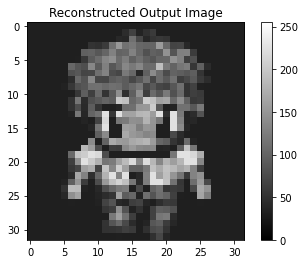

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# B は 32bit × 256ワードのリスト
# → 8bit × 1024画素の形に戻す
pixels = []

for word in B:
    # 下位8bitから順に取り出す
    p3 = (word >> 24) & 0xFF
    p2 = (word >> 16) & 0xFF
    p1 = (word >> 8)  & 0xFF
    p0 =  word        & 0xFF

    pixels.extend([p0, p1, p2, p3])

# numpy配列化（1024長）
pixels = np.array(pixels, dtype=np.uint8)


img = pixels.reshape((32, 32))

plt.imsave("output_bimage_noneshift_5_2.png", img, cmap="gray", vmin=0, vmax=255)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.colorbar()
plt.title("Reconstructed Output Image")
plt.show()